# 自編碼器資料品質檢測範例

## 一、資料品質檢測用意
　　在深度學習中，影像資料集的資料品質檢測是至關重要的，因為它直接影響模型的效能和泛化能力。透過對影像資料集進行品質檢測，可以識別和排除一些問題，如影像模糊、雜訊等，確保訓練資料的準確性和一致性。這樣可以提高深度學習模型的穩健性，使其在面對現實世界中的資料時表現更加穩健可靠。此外，良好的資料品質檢測也有助於節省訓練時間和資源，並提高模型訓練的效率。

## 二、MNIST 資料集
　　MNIST 是一個非常著名的手寫數字辨識資料集，常用於訓練和測試機器學習模型。這個資料集包含了 70,000 張大小為 28x28 像素的黑白圖片，每張圖片都是 0 到 9 的手寫數字之一。 MNIST 資料集通常被分為 60,000 張訓練圖片和 10,000 張測驗圖片，被廣泛應用於教育和研究，是電腦視覺領域的基礎資料集。


## 三、自編碼器 (AutoEncoder) 檢測流程 —— 以 MNIST 資料集為例
<i>步驟 1. 載入資料集<i><br>
> 利用 TensorFlow 的 API 載入內建的 MNIST 手寫數字資料集。這個資料集包含了成千上萬的 28x28 像素的手寫數字圖片，非常適合用於訓練影像識別模型。

<i>步驟 2. 定義正常與異常資料<i><br>
> 在本範例中，將手寫數字 '1' 定義為正常數據。其餘的數字 '0' 和 '2' 至 '9' 被定義為異常數據。

<i>步驟 3. 訓練 AutoEncoder<i><br>
> 訓練一個自編碼器模型專注於重建數字 '1' 的圖像。自編碼器是一種神經網路，它學習將輸入數據壓縮到一個低維空間並重新構建出原始輸入，目的是捕捉到數據中最重要的特徵。

<i>步驟 4. 閾值定義<i><br>
> 設定重建誤差的閾值，通過分析正常數據的重建誤差分佈來確定，以便在實際應用中有效檢測異常。

<i>步驟 5. 異常檢測<i><br>
> 使用測試集來評估自編碼器的性能。具體方法是，利用自編碼器嘗試重建測試集中的圖像，並計算重建誤差。理論上，自編碼器對於未見過的異常數據（數字 '0' 和 '2' 至 '9'）重建效果應較差，從而可以通過檢查重建誤差來識別異常。

## 步驟1. 載入資料集



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [ ]:
# 載入資料集 (訓練集圖, 訓練集標籤), _
(X_train, y_train), _ = mnist.load_data()

# 查看資料維度 (圖片數量, 高, 寬)
print(X_train.shape)

# 為了使資料集符合模型的輸入要求，我們要在資料集加上灰度通道
# (資料筆數, 高, 寬) --> (資料筆數, 高, 寬, 1)
X_train = np.expand_dims(X_train, axis=-1)

(60000, 28, 28)


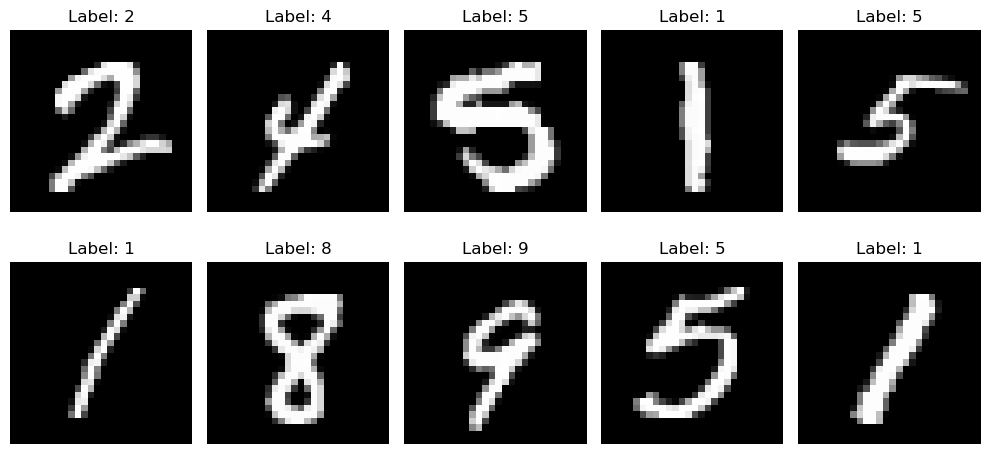

In [ ]:
# 隨機取 10 張圖的索引
indices = np.random.choice(range(len(X_train)), 10, replace=False)

plt.figure(figsize=(10, 5)) # 設定圖匡大小
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)  # 2 列, 5 欄, 子圖索引開始為 1
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 步驟 2. 定義正常與異常資料

In [ ]:
# 過濾出圖片為 '1' 作為「正常資料集」
one_images = X_train[y_train == 1]

# 其餘 '0' 和 '2-9' 作為「異常資料」
anomaly_images = X_train[y_train != 1]

# 標準化圖像數值 0~1之間
one_images = one_images.astype('float32') / 255.0
anomaly_images = anomaly_images.astype('float32') / 255.0

# 查看切割後資料集數量
print("正常資料數量('1'):", one_images.shape[0])
print("異常資料數量:('0和2~9')", anomaly_images.shape[0])
print("正常資料集形狀:", one_images.shape)
print("異常資料集形狀:", anomaly_images.shape)

正常資料數量('0'): 6742
異常資料數量:('1~9') 53258
正常資料集形狀: (6742, 28, 28, 1)
異常資料集形狀: (53258, 28, 28, 1)


In [ ]:
# 前 2000 筆當正常資料訓練集, 後 1600 當正常資料的測試集
one_images_train, one_images_test = one_images[:2000], one_images[2000:3600]

## 步驟 3. 訓練 AutoEncoder

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
IMAGE_SIZE = 28 # MNIST 資料集圖片大小
BATCH_SIZE = 32 # 訓練批量大小

In [ ]:
def ssim_loss(true, pred):
    # 計算 SSIM
    ssim = tf.image.ssim(true, pred, max_val=1.0)
    # 由於 SSIM 的範圍是 -1 到 1，其中 1 表示完全相同，將其轉換為損失值
    return 1.0 - ssim  # 轉換為損失，越低越好

In [ ]:
# 模型定義
model = Sequential(name='autoencoder')

# Encoder
model.add(Conv2D(32, (3, 3), activation='relu',
          padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name='input_layer'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_2'))


# Decoder
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_3'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_4'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_5'))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output_layer'))

model.compile(optimizer=Adam(), loss='mse', metrics=['mse', ssim_loss])
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Conv2D)        (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 output_layer (Conv2D)       (None, 28, 28, 1)         

In [ ]:
# 模型訓練
hist = model.fit(one_images_train,
                 one_images_train,
                 batch_size=BATCH_SIZE,
                 epochs=30,
                 validation_split=0.2)

Epoch 1/30
50/50 [==============================] - 10s 183ms/step - loss: 0.0286 - mse: 0.0286 - ssim_loss: 0.2003 - val_loss: 0.0023 - val_mse: 0.0023 - val_ssim_loss: 0.0344
Epoch 2/30
50/50 [==============================] - 9s 187ms/step - loss: 0.0014 - mse: 0.0014 - ssim_loss: 0.0207 - val_loss: 9.9594e-04 - val_mse: 9.9594e-04 - val_ssim_loss: 0.0163
Epoch 3/30
50/50 [==============================] - 9s 178ms/step - loss: 9.3874e-04 - mse: 9.3874e-04 - ssim_loss: 0.0148 - val_loss: 9.8710e-04 - val_mse: 9.8710e-04 - val_ssim_loss: 0.0155
Epoch 4/30
50/50 [==============================] - 9s 171ms/step - loss: 6.4950e-04 - mse: 6.4950e-04 - ssim_loss: 0.0103 - val_loss: 5.2587e-04 - val_mse: 5.2587e-04 - val_ssim_loss: 0.0093
Epoch 5/30
50/50 [==============================] - 9s 173ms/step - loss: 4.4681e-04 - mse: 4.4681e-04 - ssim_loss: 0.0074 - val_loss: 4.1647e-04 - val_mse: 4.1647e-04 - val_ssim_loss: 0.0086
Epoch 6/30
50/50 [==============================] - 9s 177ms/st

dict_keys(['loss', 'mse', 'ssim_loss', 'val_loss', 'val_mse', 'val_ssim_loss'])


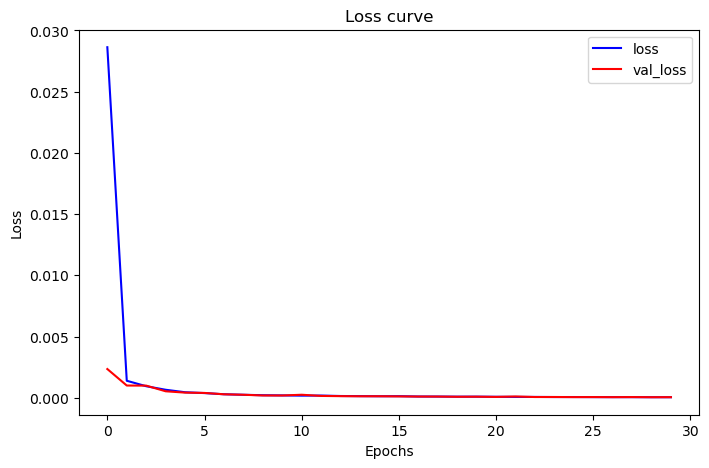

In [ ]:
# 訓練過程可視化
def plot_history(history):
    print(history.history.keys())
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.figure(figsize=(8,5))
    plt.plot(loss, "b", label="loss")
    plt.plot(val_loss, "r", label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss curve")
    plt.savefig('training_curve.png')

plot_history(hist)

1/1 [==============================] - 0s 58ms/step


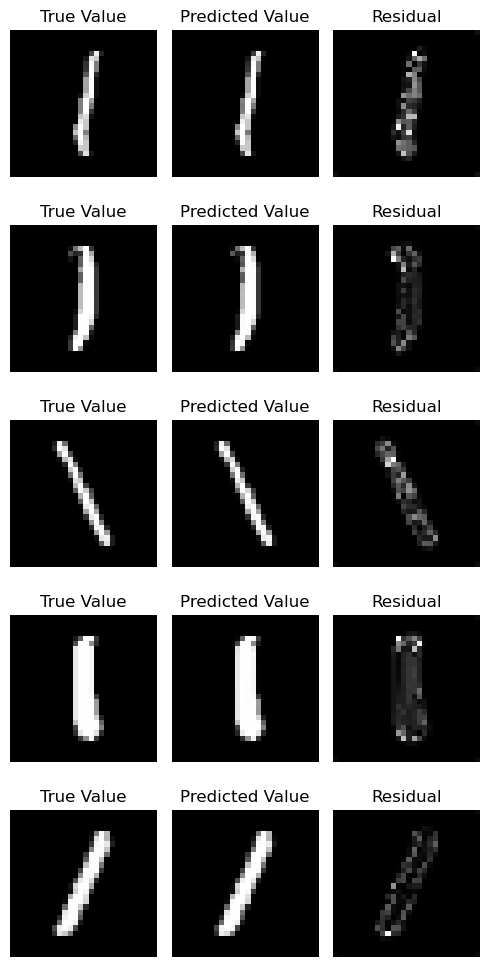

In [ ]:
# 測試集
indices = np.random.choice(range(len(one_images_test)), 5, replace=False)

test_sample = one_images_test[indices]

y_pred = model.predict(test_sample)

residuals = np.abs(test_sample - y_pred)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(5, 10))

for i in range(5):
    # 真實值
    axes[i, 0].imshow(test_sample[i], cmap='gray')
    axes[i, 0].set_title('True Value')
    axes[i, 0].axis('off')
    # 預測值
    axes[i, 1].imshow(y_pred[i], cmap='gray')
    axes[i, 1].set_title('Predicted Value')
    axes[i, 1].axis('off')
    # 殘差
    axes[i, 2].imshow(residuals[i], cmap='gray')
    axes[i, 2].set_title('Residual')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 30ms/step


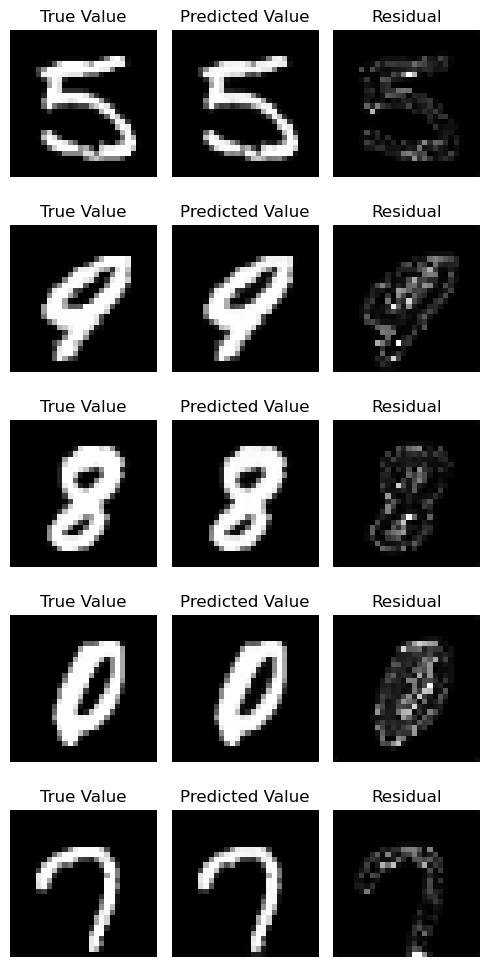

In [ ]:
# 異常資料
indices = np.random.choice(range(len(anomaly_images)), 5, replace=False)

test_sample = anomaly_images[indices]

y_pred = model.predict(test_sample)

residuals = np.abs(test_sample - y_pred)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(5, 10))

for i in range(5):
    # 真實值
    axes[i, 0].imshow(test_sample[i], cmap='gray')
    axes[i, 0].set_title('True Value')
    axes[i, 0].axis('off')
    # 預測值
    axes[i, 1].imshow(y_pred[i], cmap='gray')
    axes[i, 1].set_title('Predicted Value')
    axes[i, 1].axis('off')
    # 殘差
    axes[i, 2].imshow(residuals[i], cmap='gray')
    axes[i, 2].set_title('Residual')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## 步驟 4. 閾值定義

In [ ]:
# 紀錄 ssim 損失的清單
ssim_reconstruction_errors = []
# 紀錄 mse 損失的清單
mse_reconstruction_errors = []

for i, original_image in enumerate(one_images_train):
    print(f'第 {i + 1} 張圖片')
    # 預測圖片
    pred_image = model.predict(original_image.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    # 計算 ssim loss
    ssim = ssim_loss(original_image, pred_image.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    # 計算 mse loss
    mse = np.mean(np.power(original_image - pred_image.reshape(IMAGE_SIZE, IMAGE_SIZE, 1), 2))
    #
    ssim_reconstruction_errors.append(ssim)
    mse_reconstruction_errors.append(mse)

第 1 張圖片
1/1 [==============================] - 0s 22ms/step
第 2 張圖片
1/1 [==============================] - 0s 18ms/step
第 3 張圖片
1/1 [==============================] - 0s 18ms/step
第 4 張圖片
1/1 [==============================] - 0s 17ms/step
第 5 張圖片
1/1 [==============================] - 0s 16ms/step
第 6 張圖片
1/1 [==============================] - 0s 17ms/step
第 7 張圖片
1/1 [==============================] - 0s 15ms/step
第 8 張圖片
1/1 [==============================] - 0s 16ms/step
第 9 張圖片
1/1 [==============================] - 0s 16ms/step
第 10 張圖片
1/1 [==============================] - 0s 16ms/step
第 11 張圖片
1/1 [==============================] - 0s 19ms/step
第 12 張圖片
1/1 [==============================] - 0s 16ms/step
第 13 張圖片
1/1 [==============================] - 0s 17ms/step
第 14 張圖片
1/1 [==============================] - 0s 17ms/step
第 15 張圖片
1/1 [==============================] - 0s 16ms/step
第 16 張圖片
1/1 [==============================] - 0s 16ms/step
第 17 張圖片
1/1 [===================

In [ ]:
# 計算平均值和標準差
ssim_mean_error = np.mean(ssim_reconstruction_errors)
ssim_std_error = np.std(ssim_reconstruction_errors)
print(f'mean_error: {ssim_mean_error}')
print(f'std_error: {ssim_std_error}')

# 設定閾值
k = 3  # 根據個案調整
ssim_threshold = ssim_mean_error + k * ssim_std_error

print(f"ssim 設定的重建誤差閾值為: {ssim_threshold}")

mean_error: 0.0009695010376162827
std_error: 0.0030049211345613003
ssim 設定的重建誤差閾值為: 0.009984264441300184


In [ ]:
# 計算平均值和標準差
mse_mean_error = np.mean(mse_reconstruction_errors)
mse_std_error = np.std(mse_reconstruction_errors)
print(f'mean_error: {mse_mean_error}')
print(f'std_error: {mse_std_error}')
# 設定閾值
k = 3  # 根據個案調整
mse_threshold = mse_mean_error + k * mse_std_error

print(f"mse 設定的重建誤差閾值為: {mse_threshold}")

mean_error: 4.0365051972912624e-05
std_error: 2.8632553949137218e-05
mse 設定的重建誤差閾值為: 0.00012626271382032428


## 步驟 5. 異常檢測

1/1 [==============================] - 0s 19ms/step


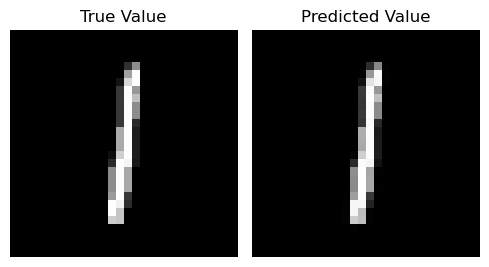

In [ ]:
pred_image = model.predict(one_images_test[1].reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
# 真實值
axes[0].imshow(one_images_test[1], cmap='gray')
axes[0].set_title('True Value')
axes[0].axis('off')
# 預測值
axes[1].imshow(pred_image[0], cmap='gray')
axes[1].set_title('Predicted Value')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 測試資料集

In [ ]:
print(f'ssim 閾值: {ssim_threshold}')
print(f'mse 閾值: {mse_threshold}')

pred_normal = 0
pred_anomaly = 0
for img in one_images_test[:100]:
    pred_image = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    # 計算
    ssim = ssim_loss(img, pred_image)[0]
    mse = np.mean(np.power(img - pred_image, 2))

    if ssim > ssim_threshold or mse > mse_threshold:
        print(f'Structural similarity index: {ssim}')
        print(f'Mean squared error: {mse}')
        print("異常檢測: 異常")
        pred_anomaly += 1
    else:
        print("異常檢測: 正常")
        pred_normal += 1

print('辨識為正常', pred_normal)
print('辨識為異常:', pred_anomaly)

ssim 閾值: 0.009984264441300184
mse 閾值: 0.00012626271382032428
1/1 [==============================] - 0s 17ms/step
異常檢測: 正常
1/1 [==============================] - 0s 16ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [==============================] - 0s 14ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [==============================] - 0s 16ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [==============================] - 0s 14ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [==============================] - 0s 15ms/step
異常檢測: 正常
1/1 [===================

### 異常資料集

In [ ]:
print(f'ssim 閾值: {ssim_threshold}')
print(f'mse 閾值: {mse_threshold}')

pred_normal = 0
pred_anomaly = 0
for img in anomaly_images[:100]:
    pred_image = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    # 計算
    ssim = ssim_loss(img, pred_image)[0]
    mse = np.mean(np.power(img - pred_image, 2))

    if ssim > ssim_threshold or mse > mse_threshold:
        print(f'Structural similarity index: {ssim}')
        print(f'Mean squared error: {mse}')
        print("異常檢測: 異常")
        pred_anomaly += 1
    else:
        print("異常檢測: 正常")
        pred_normal += 1

print('辨識為正常', pred_normal)
print('辨識為異常:', pred_anomaly)

ssim 閾值: 0.009984264441300184
mse 閾值: 0.00012626271382032428
1/1 [==============================] - 0s 61ms/step
Structural similarity index: 0.001469731330871582
Mean squared error: 0.0001413940917700529
異常檢測: 異常
1/1 [==============================] - 0s 24ms/step
Structural similarity index: 0.001617431640625
Mean squared error: 0.00015070266090333462
異常檢測: 異常
1/1 [==============================] - 0s 38ms/step
異常檢測: 正常
1/1 [==============================] - 0s 17ms/step
Structural similarity index: 0.0012410283088684082
Mean squared error: 0.0002054781507467851
異常檢測: 異常
1/1 [==============================] - 0s 17ms/step
Structural similarity index: 0.0017628669738769531
Mean squared error: 0.00018857010581996292
異常檢測: 異常
1/1 [==============================] - 0s 17ms/step
Structural similarity index: 0.0014695525169372559
Mean squared error: 0.00016035755106713623
異常檢測: 異常
1/1 [==============================] - 0s 16ms/step
Structural similarity index: 0.0017143487930297852
Mean sq